In [4]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
import yfinance as yf
from Classes import Data

In [5]:
#Tickers
tickers=["AAPL",'TSLA','SPY']

In [8]:
#LLAMAR A LA CLASE DATA
data = Data(tickers)

# Establecer fechas
data.dates("2000-01-01", "2015-12-31")

# Descargar datos
data_prices = data.datadownload()

data_rends = data.rend(data_prices)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
data_rends

Price,AAPL,TSLA,SPY
Ticker,AAPL,TSLA,SPY
Date,,,
2000-01-03,NaN,NaN,NaN
2000-01-04,-0.084310,NaN,-0.039106
2000-01-05,0.014633,NaN,0.001789
2000-01-06,-0.086538,NaN,-0.016072
2000-01-07,0.047369,NaN,0.058076
...,...,...,...
2015-12-23,0.012870,-0.001087,0.012383
2015-12-24,-0.005340,0.003788,-0.001650


In [9]:
# Escalar los datos para clustering
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns)

C:\Users\rania\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


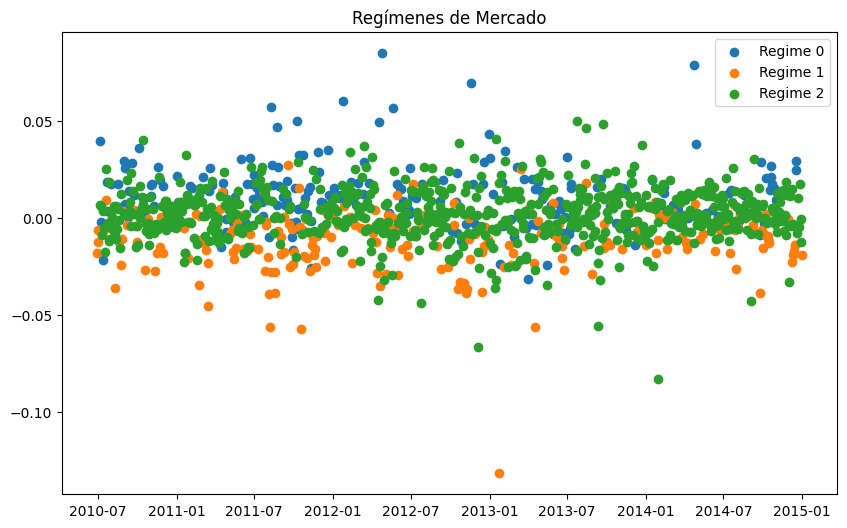

In [10]:
# Aplicar K-Means para identificar regímenes de mercado
n_clusters = 3  # Número de regímenes (puedes ajustarlo según tus datos)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
regimes = kmeans.fit_predict(scaled_returns)

# Agregar etiquetas de régimen al DataFrame
returns['Regime'] = regimes

# Visualizar los regímenes
plt.figure(figsize=(10, 6))
for regime in range(n_clusters):
    plt.scatter(returns[returns['Regime'] == regime].index,
                returns[returns['Regime'] == regime].iloc[:, 0],
                label=f'Regime {regime}')
plt.title('Regímenes de Mercado')
plt.legend()
plt.show()

In [11]:
# Función para calcular la asignación óptima de cartera
def optimize_portfolio(cov_matrix, expected_returns, risk_free_rate=0.0):
    num_assets = len(expected_returns)
    
    # Función objetivo: maximizar el Sharpe ratio
    def neg_sharpe_ratio(weights):
        portfolio_return = np.dot(weights, expected_returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio
    
    # Restricciones: pesos deben sumar 1 y ser no negativos
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = num_assets * [1. / num_assets]
    
    # Optimización
    result = minimize(neg_sharpe_ratio, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Optimización condicional para cada régimen
risk_free_rate = 0.02  # Tasa libre de riesgo (ajusta según tus datos)
optimal_weights_by_regime = {}

for regime in range(n_clusters):
    regime_data = returns[returns['Regime'] == regime].iloc[:, :-1]  # Excluir columna 'Regime'
    
    # Estimar parámetros condicionales
    cov_matrix = regime_data.cov()
    expected_returns = regime_data.mean()
    
    # Optimizar cartera
    optimal_weights = optimize_portfolio(cov_matrix, expected_returns, risk_free_rate)
    optimal_weights_by_regime[regime] = optimal_weights

# Mostrar resultados
for regime, weights in optimal_weights_by_regime.items():
    print(f"Regime {regime}: {weights}")

Regime 0: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.44328993e-15
 0.00000000e+00 2.05391260e-15 1.00000000e+00 2.02615702e-15
 5.13478149e-16]
Regime 1: [1.65145675e-15 0.00000000e+00 7.77156117e-16 1.01307851e-15
 0.00000000e+00 1.60982339e-15 1.00000000e+00 1.81799020e-15
 8.04911693e-16]
Regime 2: [0.00000000e+00 8.22814039e-14 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00]


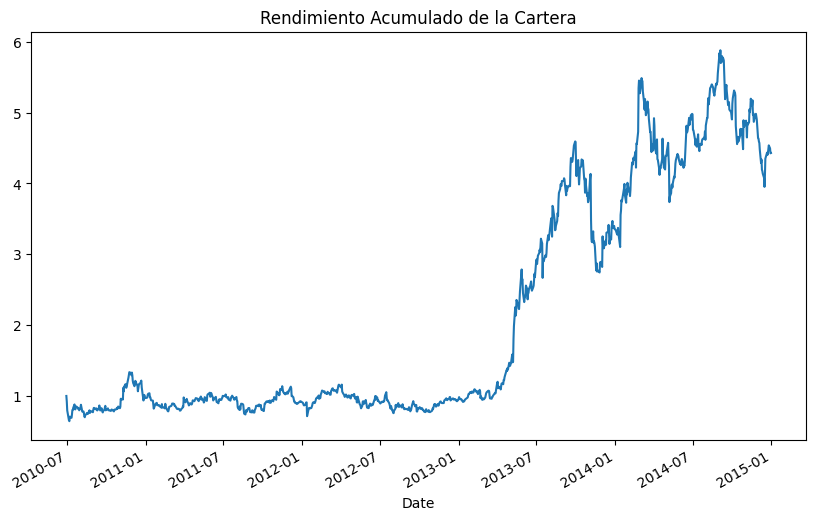

Sharpe Ratio: 0.86


In [12]:
# Simular el rendimiento de la cartera
portfolio_returns = []

for i in range(len(returns)):
    current_regime = returns.iloc[i]['Regime']
    weights = optimal_weights_by_regime[current_regime]
    daily_return = np.dot(weights, returns.iloc[i, :-1])  # Retornos diarios ponderados
    portfolio_returns.append(daily_return)

# Convertir a DataFrame
portfolio_returns = pd.Series(portfolio_returns, index=returns.index)

# Calcular métricas de rendimiento
cumulative_returns = (1 + portfolio_returns).cumprod()
sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)

# Visualizar resultados
plt.figure(figsize=(10, 6))
cumulative_returns.plot(title='Rendimiento Acumulado de la Cartera')
plt.show()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")